In [1]:
import os
import json
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [2]:
DATA_DIR = "../data"

In [3]:
final_df = pd.read_csv(f"{DATA_DIR}/processed/combined_bioassay_data.tsv", sep="\t")
final_df.head(2)

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast,chemical_class,compound_superclass,compound_pathway,best_class
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_33,5.0,5.0,NaN,6.0,"['Amino cyclitols', 'Aminoglycosides']","['Aminosugars and aminoglycosides', 'Polyols']",['Carbohydrates'],acid-fast
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_33,NaN,NaN,6.0,NaN,['Chalcones'],['Flavonoids'],['Shikimates and Phenylpropanoids'],fungi


# Getting information on chemical classes

In [4]:
from ast import literal_eval

In [5]:
chem_class_dict = defaultdict(lambda: defaultdict(set))
chem_superclass_dict = defaultdict(lambda: defaultdict(set))
chem_pathway_dict = defaultdict(lambda: defaultdict(set))

for idx, row in tqdm(final_df.iterrows(), total=len(final_df)):
    (

        inchikey,
        smiles,
        source,
        gram_pos,
        gram_neg,
        fungi,
        acid_fast,
        class_info,
        superclass_info,
        pathway_info,
        best_class,
    ) = row

    if pd.isna(class_info):
        class_info = "[]"

    if pd.isna(superclass_info):
        superclass_info = "[]"

    if pd.isna(pathway_info):
        pathway_info = "[]"

    class_info = literal_eval(class_info)
    superclass_info = literal_eval(superclass_info)
    pathway_info = literal_eval(pathway_info)


    if best_class == "gram-positive":
        for c in class_info:
            chem_class_dict["gram-positive"][c].add(inchikey)

        for c in superclass_info:
            chem_superclass_dict["gram-positive"][c].add(inchikey)

        for c in pathway_info:
            chem_pathway_dict["gram-positive"][c].add(inchikey)


    elif best_class == "gram-negative":
        for c in class_info:
            chem_class_dict["gram-negative"][c].add(inchikey)

        for c in superclass_info:
            chem_superclass_dict["gram-negative"][c].add(inchikey)

        for c in pathway_info:
            chem_pathway_dict["gram-negative"][c].add(inchikey)


    elif best_class == "fungi":

        for c in class_info:
            chem_class_dict["fungi"][c].add(inchikey)

        for c in superclass_info:
            chem_superclass_dict["fungi"][c].add(inchikey)

        for c in pathway_info:
            chem_pathway_dict["fungi"][c].add(inchikey)


    elif best_class == "acid-fast":

        for c in class_info:
            chem_class_dict["acid-fast"][c].add(inchikey)

        for c in superclass_info:
            chem_superclass_dict["acid-fast"][c].add(inchikey)

        for c in pathway_info:
            chem_pathway_dict["acid-fast"][c].add(inchikey)

  0%|          | 0/77442 [00:00<?, ?it/s]

100%|██████████| 77442/77442 [00:07<00:00, 10744.17it/s]


# Looking for unique classes

In [6]:
chem_class_counter_dict = {
    "gram-positive": {},
    "gram-negative": {},
    "fungi": {},
    "acid-fast": {},
}

for k, v in chem_class_dict.items():
    for kk, vv in v.items():
        chem_class_counter_dict[k][kk] = len(vv)

# chem_superclass_dict = defaultdict(lambda: defaultdict(set))
# chem_pathway_dict = defaultdict(lambda: defaultdict(set))

In [7]:
len(chem_class_counter_dict["gram-positive"]), len(
    chem_class_counter_dict["gram-negative"]
), len(chem_class_counter_dict["fungi"]), len(chem_class_counter_dict["acid-fast"])

(354, 256, 208, 206)

In [8]:
gram_pos_classes = set(chem_class_counter_dict["gram-positive"].keys())
gram_neg_classes = set(chem_class_counter_dict["gram-negative"].keys())
fungi_classes = set(chem_class_counter_dict["fungi"].keys())
acid_fast_classes = set(chem_class_counter_dict["acid-fast"].keys())

In [9]:
from utils import draw_venn

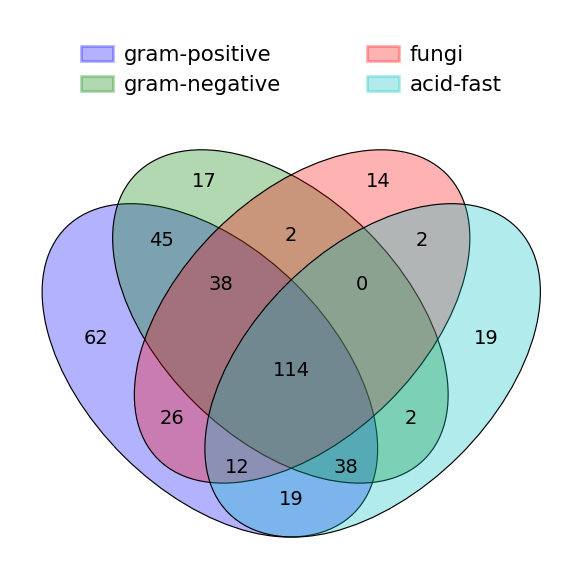

In [10]:
draw_venn(
    {
        "gram-positive": gram_pos_classes,
        "gram-negative": gram_neg_classes,
        "fungi": fungi_classes,
        "acid-fast": acid_fast_classes,
    }
)

In [11]:
gram_pos_only = gram_pos_classes - gram_neg_classes - fungi_classes - acid_fast_classes
gram_neg_only = gram_neg_classes - gram_pos_classes - fungi_classes - acid_fast_classes
fungi_only = fungi_classes - gram_pos_classes - gram_neg_classes - acid_fast_classes
acid_fast_only = acid_fast_classes - gram_pos_classes - gram_neg_classes - fungi_classes

In [12]:
len(gram_pos_only), len(gram_neg_only), len(fungi_only), len(acid_fast_only)

(62, 17, 14, 19)

In [23]:
def get_distiribution_plot(class_dict: dict, info_name: str):
    df_data = []

    for class_name in tqdm(class_dict):
        cmpd_couner = chem_class_counter_dict[info_name][class_name]
        df_data.append(
            {
                "class": class_name,
                "compound_count": cmpd_couner,
            }
        )
    
    df = pd.DataFrame(df_data)
    df.sort_values("compound_count", ascending=False, inplace=True)
    df["percentage"] = df["compound_count"] / df["compound_count"].sum() * 100
    df["percentage"] = df["percentage"].round(2)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x="class", y="percentage", data=df)
    plt.xticks(rotation=90)
    plt.show()

100%|██████████| 17/17 [00:00<00:00, 41383.15it/s]


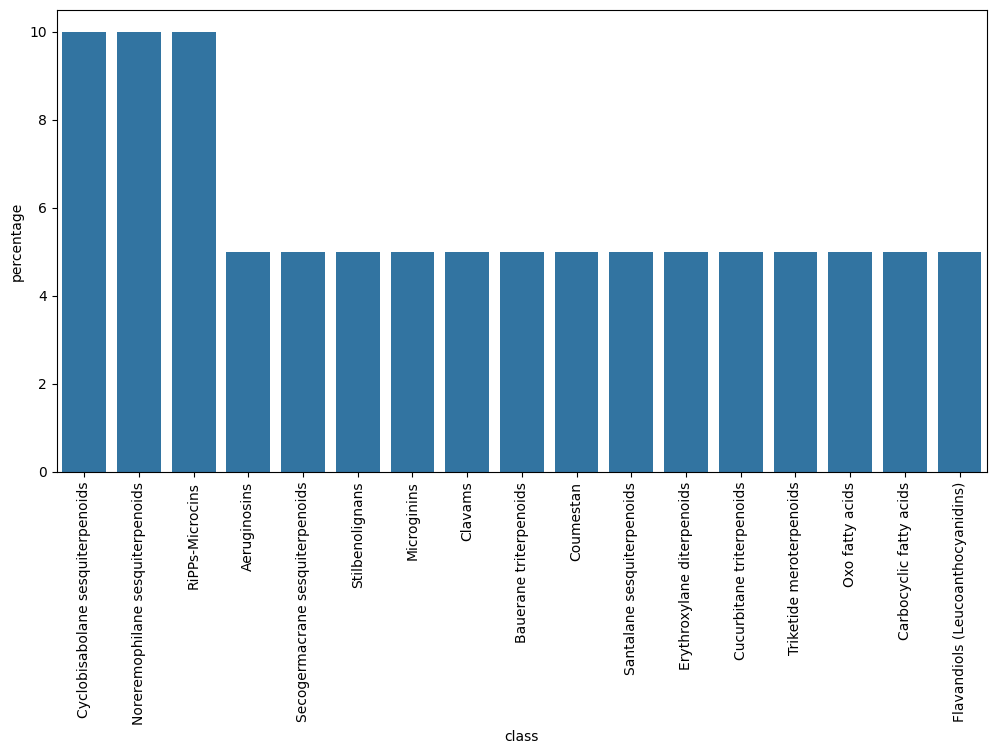

In [24]:
get_distiribution_plot(class_dict=gram_neg_only, info_name="gram-negative")

100%|██████████| 62/62 [00:00<00:00, 119726.91it/s]


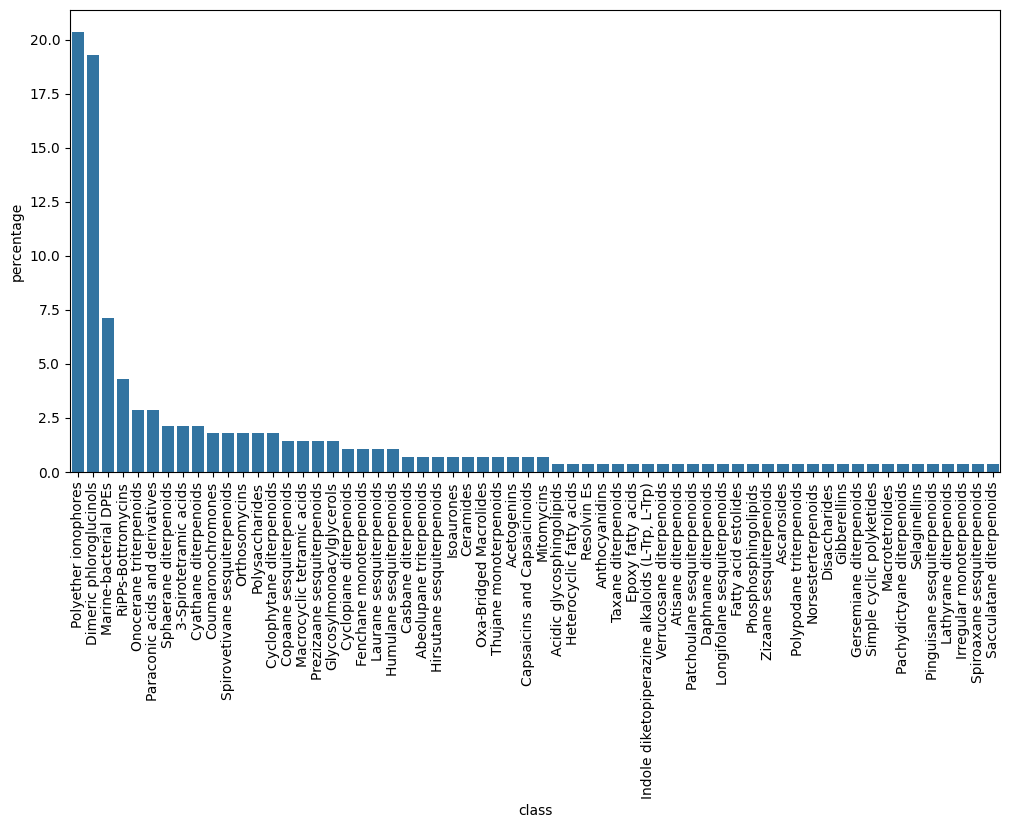

In [25]:
get_distiribution_plot(class_dict=gram_pos_only, info_name="gram-positive")

100%|██████████| 19/19 [00:00<00:00, 50310.46it/s]


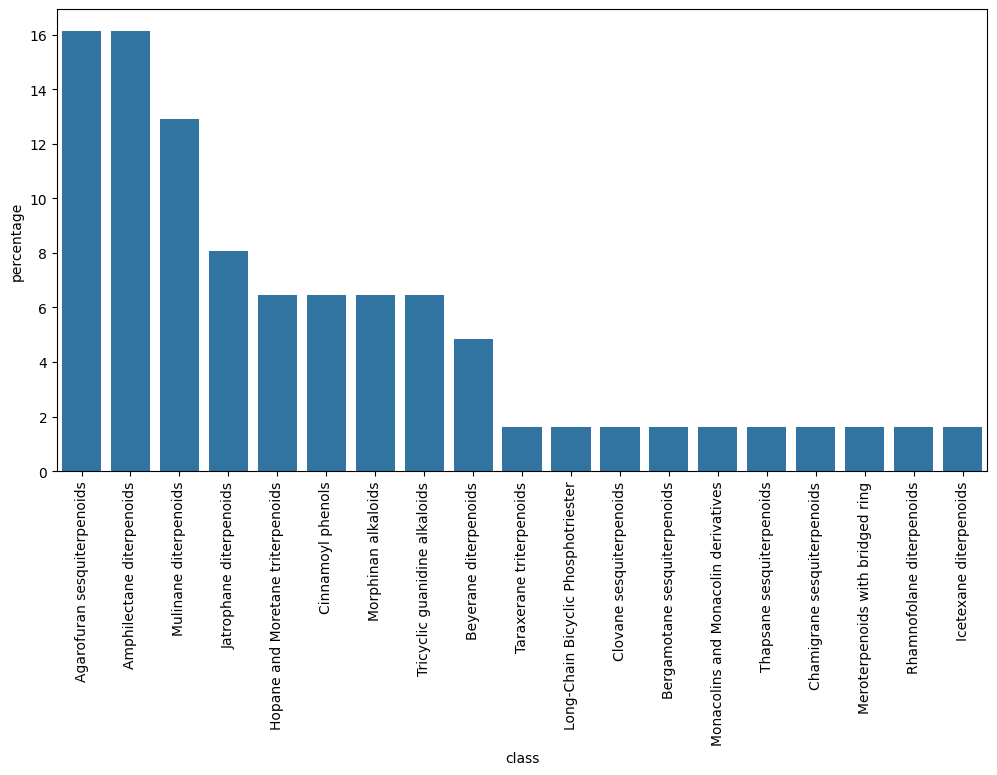

In [26]:
get_distiribution_plot(class_dict=acid_fast_only, info_name="acid-fast")

100%|██████████| 14/14 [00:00<?, ?it/s]


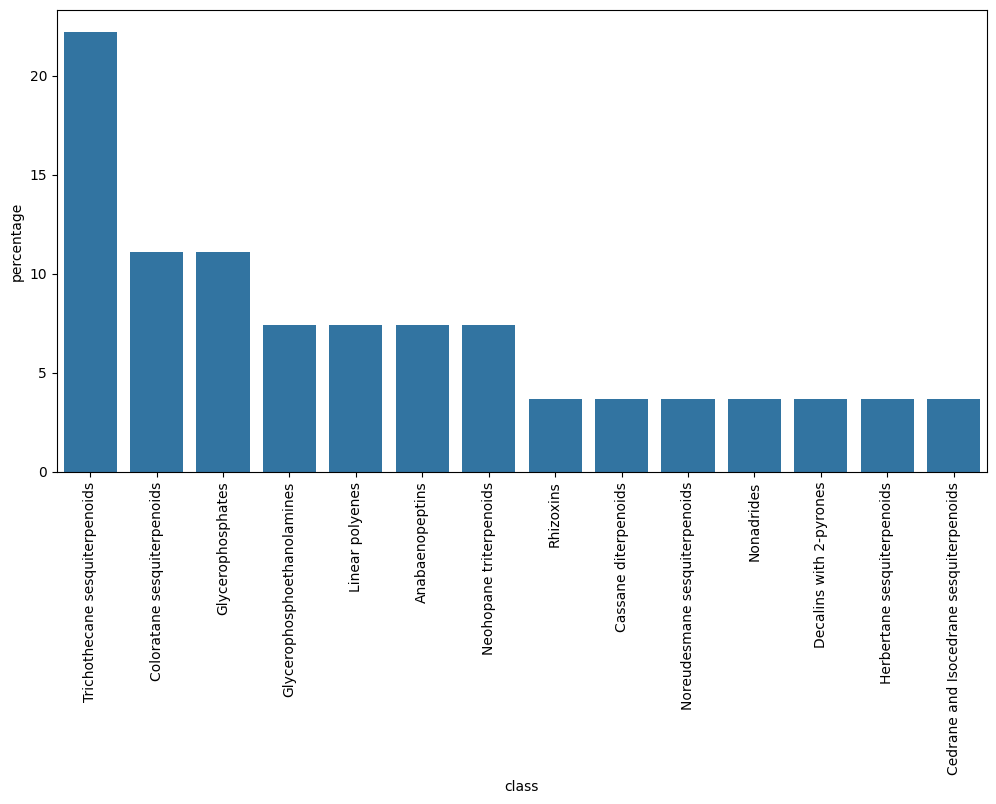

In [27]:
get_distiribution_plot(class_dict=fungi_only, info_name="fungi")

# Superclasses

In [28]:
chem_superclass_counter_dict = {
    "gram-positive": {},
    "gram-negative": {},
    "fungi": {},
    "acid-fast": {},
}

for k, v in chem_superclass_dict.items():
    for kk, vv in v.items():
        chem_superclass_counter_dict[k][kk] = len(vv)

In [29]:
len(chem_superclass_counter_dict["gram-positive"]), len(
    chem_superclass_counter_dict["gram-negative"]
), len(chem_superclass_counter_dict["fungi"]), len(chem_superclass_counter_dict["acid-fast"])

(66, 59, 52, 53)

In [30]:
gram_pos_superclasses = set(chem_superclass_counter_dict["gram-positive"].keys())
gram_neg_superclasses = set(chem_superclass_counter_dict["gram-negative"].keys())
fungi_superclasses = set(chem_superclass_counter_dict["fungi"].keys())
acid_fast_superclasses = set(chem_superclass_counter_dict["acid-fast"].keys())

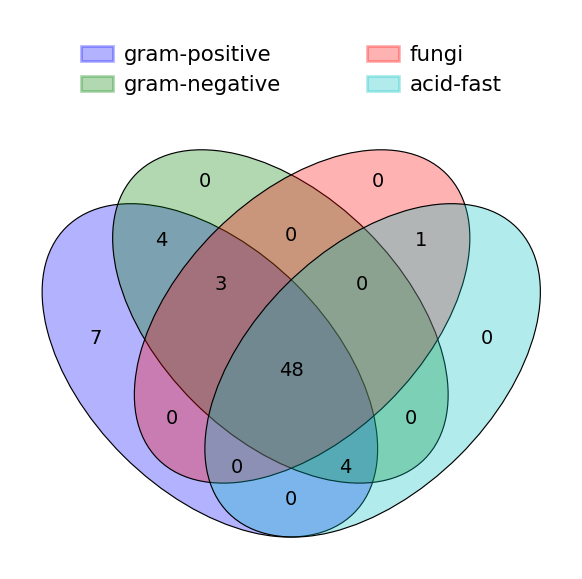

In [31]:
draw_venn(
    {
        "gram-positive": gram_pos_superclasses,
        "gram-negative": gram_neg_superclasses,
        "fungi": fungi_superclasses,
        "acid-fast": acid_fast_superclasses,
    }
)

In [36]:
gram_pos_only_superclasses = (
    gram_pos_superclasses - gram_neg_superclasses - fungi_superclasses - acid_fast_superclasses
)

In [57]:
def get_superclass_distiribution_plot(class_dict: dict, info_name: str):
    df_data = []

    for class_name in tqdm(class_dict):
        cmpd_couner = chem_superclass_counter_dict[info_name][class_name]
        df_data.append(
            {
                "class": class_name,
                "compound_count": cmpd_couner,
            }
        )
    
    df = pd.DataFrame(df_data)
    df.sort_values("compound_count", ascending=False, inplace=True)
    df = df[1:]
    # df["percentage"] = df["compound_count"] / df["compound_count"].sum() * 100
    # df["percentage"] = df["percentage"].round(2)
    
    plt.figure(figsize=(12, 6))
    # sns.barplot(x="class", y="percentage", data=df)
    plt.pie(df["compound_count"], labels=df["class"], autopct='%1.0f%%')
    # plt.xticks(rotation=90)
    plt.show()

100%|██████████| 7/7 [00:00<?, ?it/s]


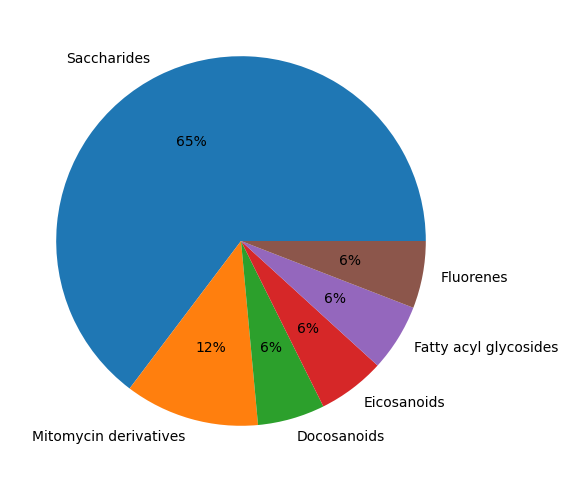

In [58]:
get_superclass_distiribution_plot(class_dict=gram_pos_only_superclasses, info_name="gram-positive")

In [59]:
gram_negative_info_1 = gram_neg_superclasses.intersection(gram_pos_superclasses)
gram_negative_info_2 = gram_neg_superclasses.intersection(fungi_superclasses)
gram_negative_info_3 = gram_neg_superclasses.intersection(acid_fast_superclasses)
len(gram_negative_info_1), len(gram_negative_info_2), len(gram_negative_info_3)

(59, 51, 52)

In [60]:
common_gram_neg_info = gram_negative_info_1.intersection(gram_negative_info_2).intersection(gram_negative_info_3)
gram_negative_info_1 = gram_negative_info_1 - common_gram_neg_info
gram_negative_info_2 = gram_negative_info_2 - common_gram_neg_info
gram_negative_info_3 = gram_negative_info_3 - common_gram_neg_info

In [61]:
len(gram_negative_info_1), len(gram_negative_info_2), len(gram_negative_info_3)

(11, 3, 4)

100%|██████████| 11/11 [00:00<?, ?it/s]


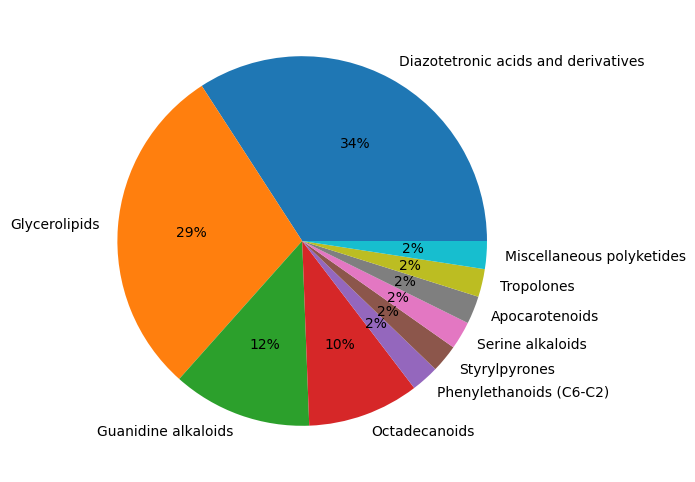

In [62]:
get_superclass_distiribution_plot(class_dict=gram_negative_info_1, info_name="gram-negative")

100%|██████████| 3/3 [00:00<?, ?it/s]


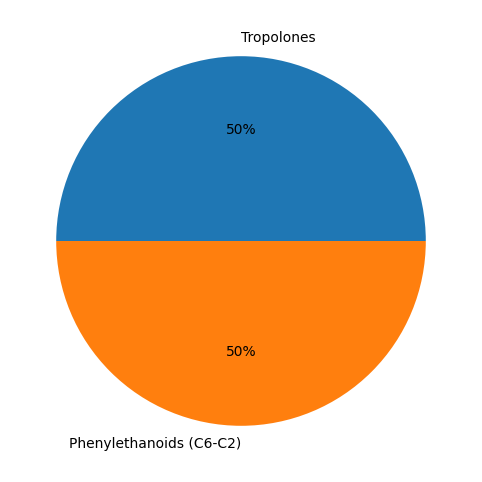

In [63]:
get_superclass_distiribution_plot(class_dict=gram_negative_info_2, info_name="gram-negative")

100%|██████████| 4/4 [00:00<?, ?it/s]


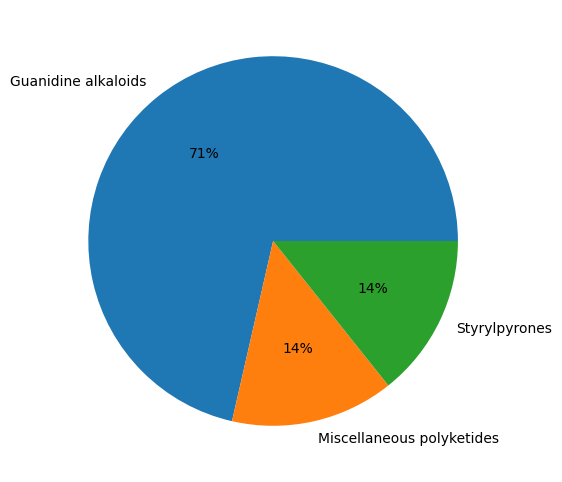

In [64]:
get_superclass_distiribution_plot(class_dict=gram_negative_info_3, info_name="gram-negative")